## 1- Importing libraries and Reading Data

In [27]:
import numpy as np
import pandas as pd
import pywt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Softmax, Bidirectional, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import csv
from typing import List, Tuple
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

In [4]:
import zipfile
import os

zip_path = 'mitbih_database.zip'
extract_path = 'mitbih_database'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
extracted_path = 'mitbih_database/mitbih_database'
extracted_files = os.listdir(extracted_path)
print(extracted_files)

['108annotations.txt', '223.csv', '232annotations.txt', '115annotations.txt', '100annotations.txt', '222.csv', '234.csv', '220.csv', '208.csv', '220annotations.txt', '228annotations.txt', '107annotations.txt', '112annotations.txt', '209.csv', '221.csv', '219.csv', '231.csv', '113annotations.txt', '106annotations.txt', '234annotations.txt', '221annotations.txt', '230.csv', '232.csv', '101annotations.txt', '114annotations.txt', '109annotations.txt', '233annotations.txt', '233.csv', '103annotations.txt', '116annotations.txt', '122.csv', '231annotations.txt', '123.csv', '111annotations.txt', '104annotations.txt', '121.csv', '109.csv', '223annotations.txt', '108.csv', '119annotations.txt', '222annotations.txt', '118.csv', '124.csv', '118annotations.txt', '105annotations.txt', '119.csv', '230annotations.txt', '117annotations.txt', '102annotations.txt', '117.csv', '103.csv', '123annotations.txt', '102.csv', '116.csv', '219annotations.txt', '203annotations.txt', '100.csv', '114.csv', '124annot

In [6]:
%pip install PyWavelets
%pip install --upgrade seaborn

In [7]:
classes = ['N', 'A', 'V', 'F', 'f']
n_classes = 5
count_classes = [0]*5

X = list()
y = list()

In [8]:
path = 'mitbih_database/'
filenames = next(os.walk(extracted_path))[2]
records = list()
annotations = list()
filenames.sort()
print(filenames)

['100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotations.txt', '205.csv', '205annotations.txt', '207.csv', '207annotations.txt', '208.csv', '208annotations.txt', '209.csv'

In [9]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    if(file_extension == '.csv'):
        records.append(path + "mitbih_database/" +filename + file_extension)
    else:
        annotations.append(path + "mitbih_database/" +filename + file_extension)

In [10]:
file_name = os.path.basename(annotations[0])
print(file_name)

100annotations.txt


## 2-Data Denosing and Preprocessing

In [11]:
def denoise(data):
    # using sym4 wavelet - best choice for ECG signals
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    
    # threshold value for noise removal 
    threshold = 0.04

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    
    # removing noise using threshold
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    # reconstructing clean signal
    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec

In [12]:
def process_signal_file(file_path: str) -> List[int]:
    # this function reads ECG signal from csv file , we only take second column because it has signal values 
    # first column has time values but we dont need them
    with open(file_path, 'rt') as signal_file:
        reader = csv.reader(signal_file, delimiter=',', quotechar='|')
        return [int(row[1]) for row in reader if row and row[1].strip().isdigit()]

In [13]:
def extract_annotations(file_path: str, valid_classes: List[str]) -> List[Tuple[int, str]]:
    # this function reads annotation file and gets important points
    # we need to know where heartbeats are in the signal
    # we only take position and label if label is in my valid_classes list
    annotations = []
    with open(file_path, 'r') as ann_file:
        next(ann_file) 
        for line in ann_file:
            parts = line.strip().split()
            if len(parts) >= 3:
                try:
                    position = int(parts[1])
                    label = parts[2]
                    if label in valid_classes:
                        annotations.append((position, label))
                except ValueError:
                    continue
    return annotations

In [14]:
def extract_segments(signal_data: List[float], 
                    annotations: List[Tuple[int, str]], 
                    window_size: int, 
                    valid_classes: List[str]) -> Tuple[np.ndarray, np.ndarray]:
    # this function cuts signal into small pieces for each heartbeat
    # we use window_size to get equal parts before and after the heartbeat point
    # we also count how many times we see each class type
    segments = []
    labels = []
    class_counts = {label: 0 for label in valid_classes}
    signal_length = len(signal_data)

    for position, label in annotations:
        if window_size <= position < signal_length - window_size:
            segment = signal_data[position - window_size:position + window_size]
            segments.append(segment)
            class_idx = valid_classes.index(label)
            labels.append(class_idx)
            class_counts[label] += 1

    return np.array(segments), np.array(labels), class_counts

In [15]:
# i choose WINDOW_SIZE as 180 because research papers say its best for ECG
# this means i take 180 samples before and after each heartbeat point
WINDOW_SIZE = 180
segments_list = []
labels_list = []
total_class_counts = {label: 0 for label in classes}

for record_file, annotation_file in zip(records, annotations):
    # first i clean the noise from signal
    signal_data = denoise(process_signal_file(record_file))
    
    # then i get the important points where heartbeats happen
    valid_annotations = extract_annotations(annotation_file, classes)
    
    # finally i cut the signal into pieces around each heartbeat
    segments, labels, counts = extract_segments(
        signal_data, 
        valid_annotations, 
        WINDOW_SIZE, 
        classes
    )
    
    segments_list.append(segments)
    labels_list.append(labels)
    for label, count in counts.items():
        total_class_counts[label] += count

# combine all the pieces i collected from different files
X = np.concatenate(segments_list, axis=0)
y = np.concatenate(labels_list, axis=0)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print("Class distribution:", total_class_counts)

Dataset shape: X=(86470, 360), y=(86470,)
Class distribution: {'N': 75011, 'A': 2546, 'V': 7129, 'F': 802, 'f': 982}


## 3- Data Visualization and Balancing

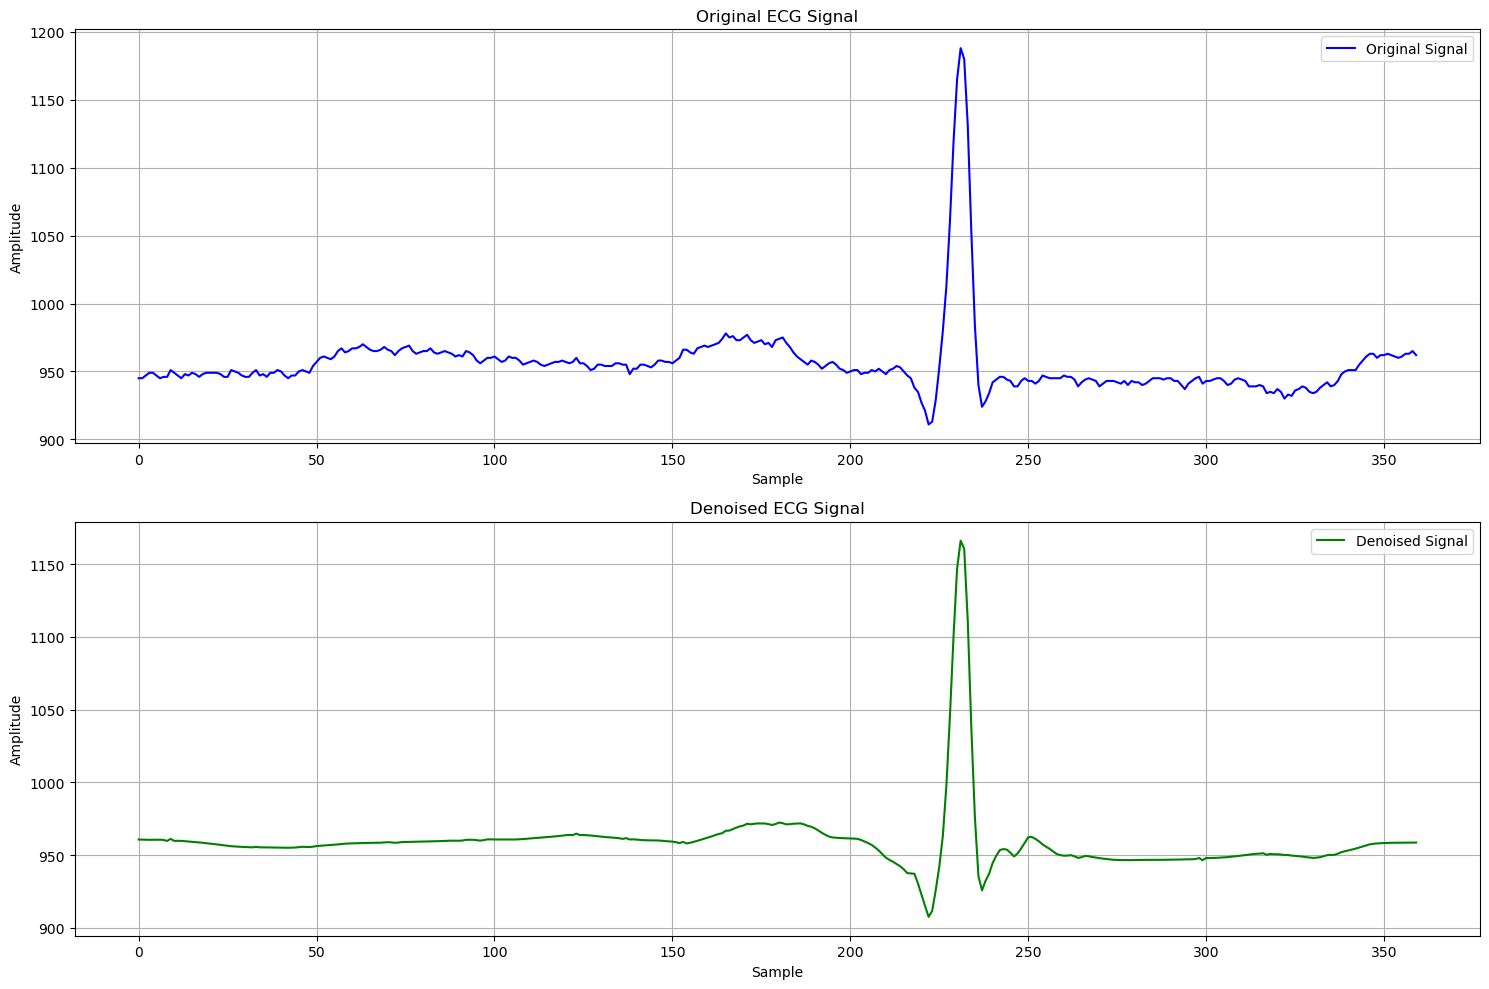

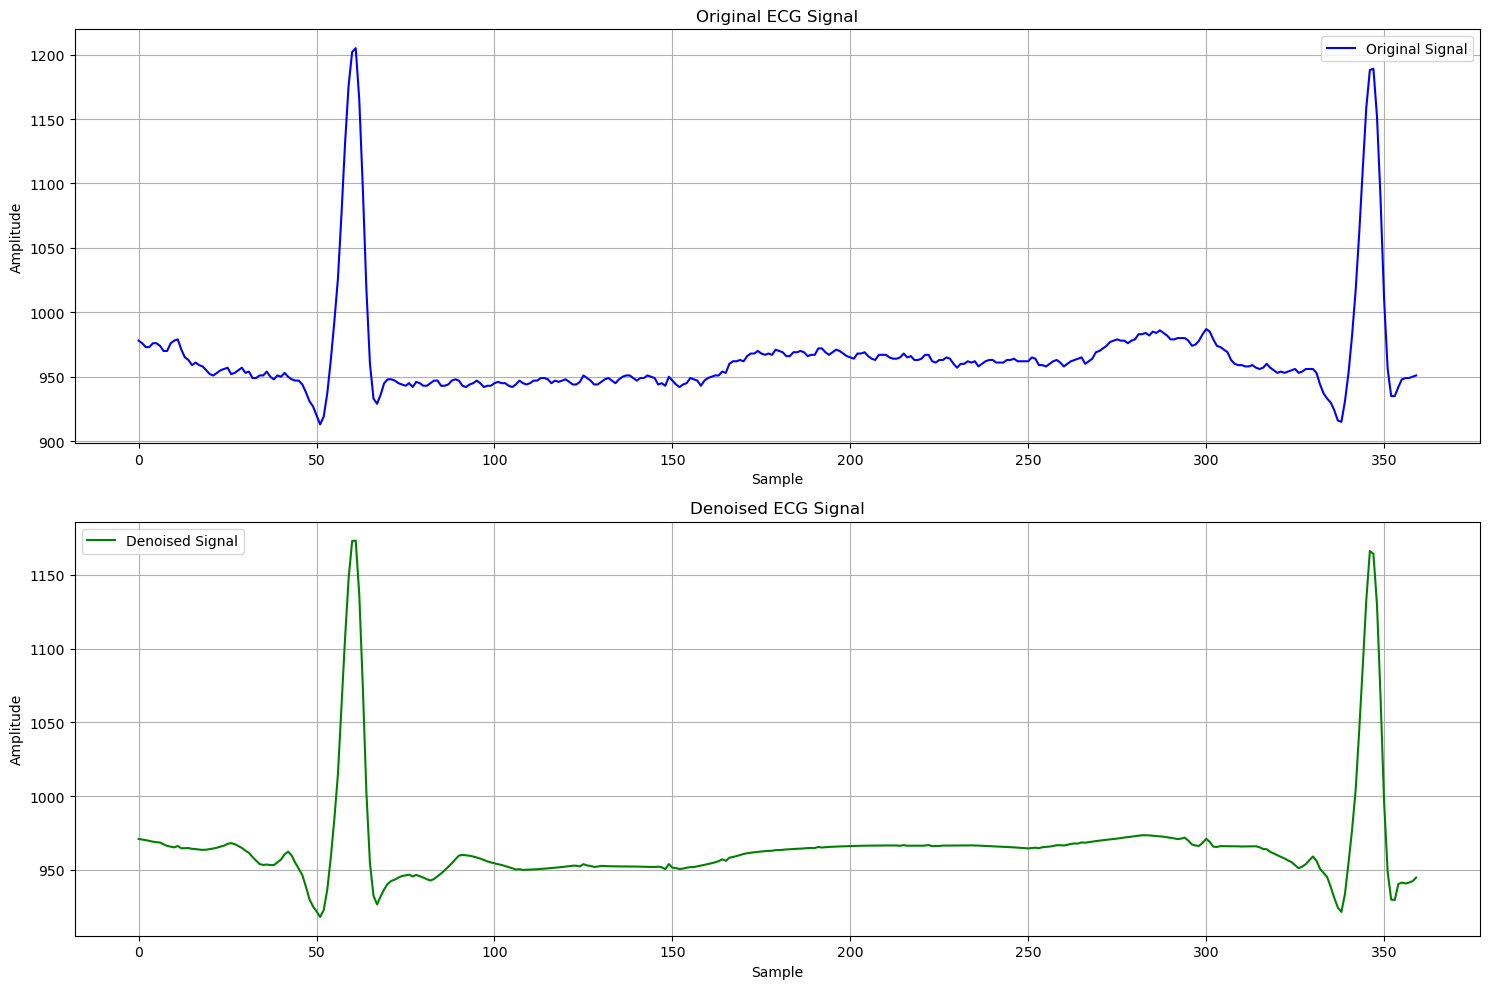

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_ecg_signals(signal_data, denoised_signal=None, window_size=360, sample_index=1000):
    # we are visualizing original and denoised signal
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(signal_data[sample_index:sample_index+window_size], 
             label='Original Signal', color='blue')
    plt.title('Original ECG Signal')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    
    if denoised_signal is not None:
        plt.subplot(2, 1, 2)
        plt.plot(denoised_signal[sample_index:sample_index+window_size], 
                 label='Denoised Signal', color='green')
        plt.title('Denoised ECG Signal')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

signal_data = process_signal_file(records[0])
denoised_signal = denoise(signal_data)

visualize_ecg_signals(signal_data, denoised_signal)

visualize_ecg_signals(signal_data, denoised_signal, sample_index=5000)

In [17]:
def split(X , y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_test = pd.DataFrame(X_test)
    X_train = pd.DataFrame(X_train)
    y_test = pd.DataFrame(y_test)
    y_train = pd.DataFrame(y_train)
    return X_train , X_test , y_train , y_test

In [18]:
X_df = pd.DataFrame(X)

In [19]:
y_df = pd.DataFrame(y)

In [20]:
X_train_default , X_test_default , y_train_default , y_test_default = split(X_df,y_df)

In [21]:
train_data = pd.concat([X_df, y_df.reset_index(drop=True)], axis=1)
train_data.columns = list(X_df.columns) + ['label']

# i need to balance my dataset because some classes have too many samples (N , V)
# and some classes have too few samples (A , F , f)
balanced_train_data = []
for label in train_data['label'].unique():
    class_data = train_data[train_data['label'] == label]
    # if class has more than 7000 samples, we take only 7000 random samples (7000 is choosen via experiments)
    if len(class_data) > 7000:
        balanced_class_data = resample(class_data, replace=False, n_samples=7000, random_state=42)
    # if class has less than 7000 samples, we create new samples by copying until i have 7000
    else:
        balanced_class_data = resample(class_data, replace=True, n_samples=7000, random_state=42)
    balanced_train_data.append(balanced_class_data)

# combine all balanced classes into one dataset
balanced_train_data = pd.concat(balanced_train_data)

X_balanced = balanced_train_data.drop(columns=['label'])
y_balanced = balanced_train_data['label']

print(y_balanced.value_counts())

label
0    7000
1    7000
2    7000
4    7000
3    7000
Name: count, dtype: int64


In [22]:
X_train , X_test , y_train , y_test = split(X_balanced,y_balanced)

In [23]:
X_test.shape

(7000, 360)

In [24]:
X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_lstm = to_categorical(y_train)
y_test_lstm = to_categorical(y_test)

## 4- Creating Feature Extraction Model (BiLSuTM)

In [49]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

with tf.device('/GPU:0'):
    # this is our first model of hybrid model we are using bidirectional LSTM and flatten layer to EXTRACT features
    model1 = Sequential()
    model1.add(Bidirectional(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(X_train_lstm.shape[1], 1))))
    model1.add(Bidirectional(LSTM(units=10, return_sequences=True, activation='tanh')))
    model1.add(Flatten())
    model1.add(Dropout(0.5))
    model1.add(Dense(35))
    model1.add(Dense(5))
    model1.add(Softmax())

    model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
        filepath="best_model.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1
    )

    history = model1.fit(
        X_train_lstm,
        y_train_lstm,
        batch_size=128,
        epochs=40,
        verbose=1,
        validation_data=(X_test_lstm, y_test_lstm),
        callbacks=[checkpoint]
    )

    score1 = model1.evaluate(X_test_lstm, y_test_lstm)
    print(f"Test Accuracy: {score1[1]}")


In [31]:
from tensorflow.keras.models import load_model, Model
model1 = load_model('best_model.keras')

In [32]:
# Our extraction model BiLTSM extracted 7200 features from our dataset
model_feat = Model(inputs=model1.layers[0].input, outputs=model1.get_layer('flatten_1').output)
feat_train = model_feat.predict(X_train_lstm)
print(feat_train.shape)
feat_test = model_feat.predict(X_test_lstm)
print(feat_test.shape)

875/875 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step
(28000, 7200)
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step
(7000, 7200)


In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# we scale our features to make them ready for PCA
feat_train_scaled = scaler.fit_transform(feat_train)
feat_test_scaled = scaler.transform(feat_test)

print(feat_train_scaled.shape)
print(feat_test_scaled.shape)

(28000, 7200)
(7000, 7200)


## 5- Feature Reduction (PCA)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.90)

# we use PCA to reduce the dimensionality of our features
# we choose 0.90 because it means 90% of variance is kept and in experiments it works best in case of time and accuracy
feat_train_pca = pca.fit_transform(feat_train_scaled)
feat_test_pca = pca.transform(feat_test_scaled)
print(feat_train_pca.shape)
print(feat_test_pca.shape)

(28000, 63)
(7000, 63)


## 6- Classification (RandomForestClassifier)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

start_time = time.time()

# we use RandomForestClassifier to classify our signal
rf_classifier = RandomForestClassifier(n_estimators=180, random_state=42)

rf_classifier.fit(feat_train_pca, y_train)

y_pred = rf_classifier.predict(feat_test_pca)
end_time = time.time()

accuracy = round(accuracy_score(y_test, y_pred) ,4)

print(f"Hybrid Model Final Accuracy: {accuracy:.4f}")
print(f"Training and prediction time: {end_time - start_time:.2f} seconds")


/Users/dogukanaytekin/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Hybrid Model Final Accuracy: 0.9859
Training and prediction time: 20.18 seconds


## Let's try to make RandomForestClassifier to raw data , classify it without feature extraction and feature reduction methods.


In [28]:
start_time = time.time()

# we tried to make RandomForestClassifier to balanced data from begining of the project
rf_direct = RandomForestClassifier(n_estimators=180, random_state=42)
rf_direct.fit(X_train_default, y_train_default)

y_pred_direct = rf_direct.predict(X_test_default)

end_time = time.time()

direct_rf_accuracy = round(accuracy_score(y_test_default, y_pred_direct), 4)

print(f"Random Forest Model Accuracy: {direct_rf_accuracy:.4f}")
print(f"Training and prediction time: {end_time - start_time:.2f} seconds")

/Users/dogukanaytekin/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Model Accuracy: 0.9807
Training and prediction time: 600.43 seconds


## Finally we can see that our hybrid model works nearly 30 times faster than single model and it has better accuracy.

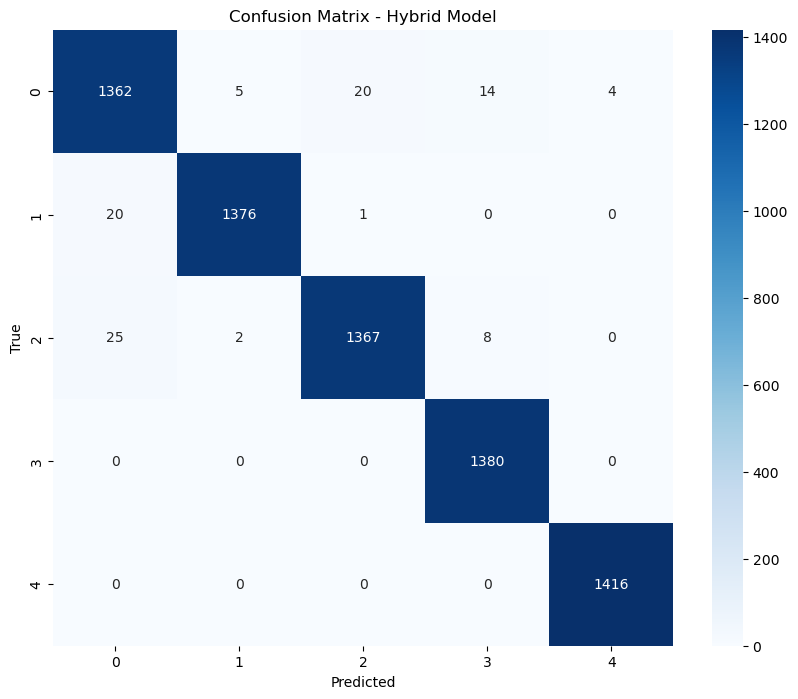


Classification Report:
              precision    recall  f1-score   support

           N       0.97      0.97      0.97      1405
           A       0.99      0.98      0.99      1397
           V       0.98      0.98      0.98      1402
           F       0.98      1.00      0.99      1380
           f       1.00      1.00      1.00      1416

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000


Direct Random Forest Model Evaluation Metrics:


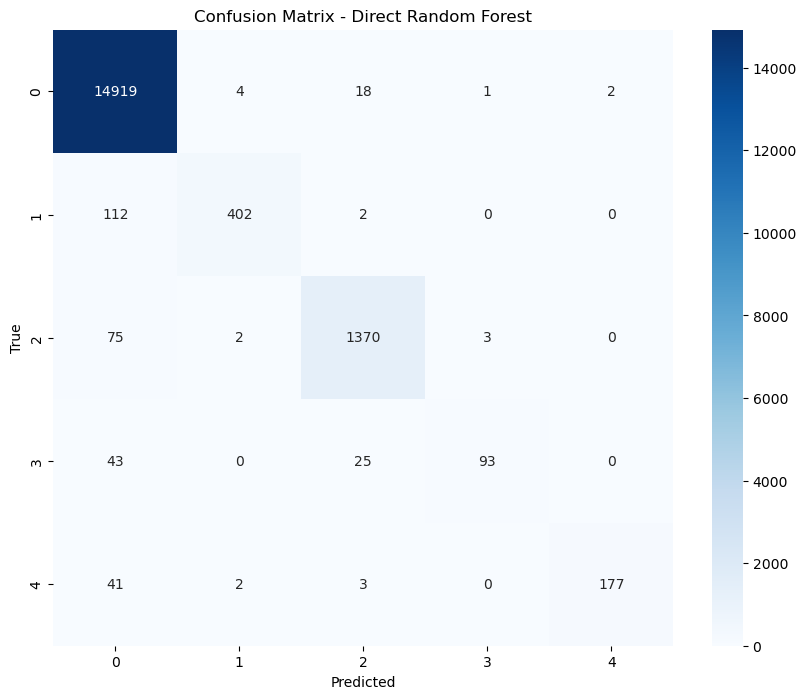


Classification Report - Direct Random Forest:
              precision    recall  f1-score   support

           N       0.98      1.00      0.99     14944
           A       0.98      0.78      0.87       516
           V       0.97      0.94      0.96      1450
           F       0.96      0.58      0.72       161
           f       0.99      0.79      0.88       223

    accuracy                           0.98     17294
   macro avg       0.98      0.82      0.88     17294
weighted avg       0.98      0.98      0.98     17294



In [37]:

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Hybrid Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

print("\nDirect Random Forest Model Evaluation Metrics:")
cm_direct = confusion_matrix(y_test_default, y_pred_direct)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_direct, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Direct Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report - Direct Random Forest:")
print(classification_report(y_test_default, y_pred_direct, target_names=classes))